# <center>Kaggle赛题 - 美国埃姆斯市房价预测</center>

## 1. 赛题介绍

美国埃姆斯市房价预测赛题在kaggle上被归类为getting start级别，属于入门级的比赛项目。它的比赛任务比较简单，就是要求参赛者根据房屋的不同特征，比如是否有地下室，是否有游泳池，房屋占地面积等，来预测房价，属于回归类任务。

相关数据集由官方提供，可直接在官网上下载。它有`train.csv`和`test.csv`两个文件，分别表示训练集和测试集，总共包含80个不同特征。比如：

- SalePrice 房价，目标变量
- MSSubclass 住宅类型
- MSZoning 区域分类
- Utilities 可利用的公共资源类型
- LandSlope 坡度
- OverallCond 房屋总体状况评分
- YearBuilt 房屋建造年份
- RoofStyle 屋顶类型
- RoofMatl 屋顶材质

其他特征的相关描述可查看官方提供的`data description.txt`文件。

比赛采用均方根误差（RMSE）作为模型评估。

## 2. 导入数据与相关的库

In [1]:
# 导入相关的模块

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid')

import warnings
warnings.filterwarnings('ignore')

# from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import RobustScaler,LabelEncoder
from collections import Counter

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from mlxtend.regressor import StackingCVRegressor

In [2]:
# 导入数据集

train = pd.read_csv('house_price_train.csv')
test = pd.read_csv('house_price_test.csv')

In [3]:
print('train set size:',train.shape)
print('test set size:',test.shape)

train set size: (1460, 81)
test set size: (1459, 80)


训练集有1460个样本，测试集有1459个样本。

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


由于ID通常对最后的预测不起作用，这里可以将其去掉。

In [4]:
# 删除train和test中的ID列

train_id = train['Id']
test_id = test['Id']
train.drop('Id',axis=1,inplace=True)
test.drop('Id',axis=1,inplace=True)



## 3. 数据探索

### 3.1 查看相关性

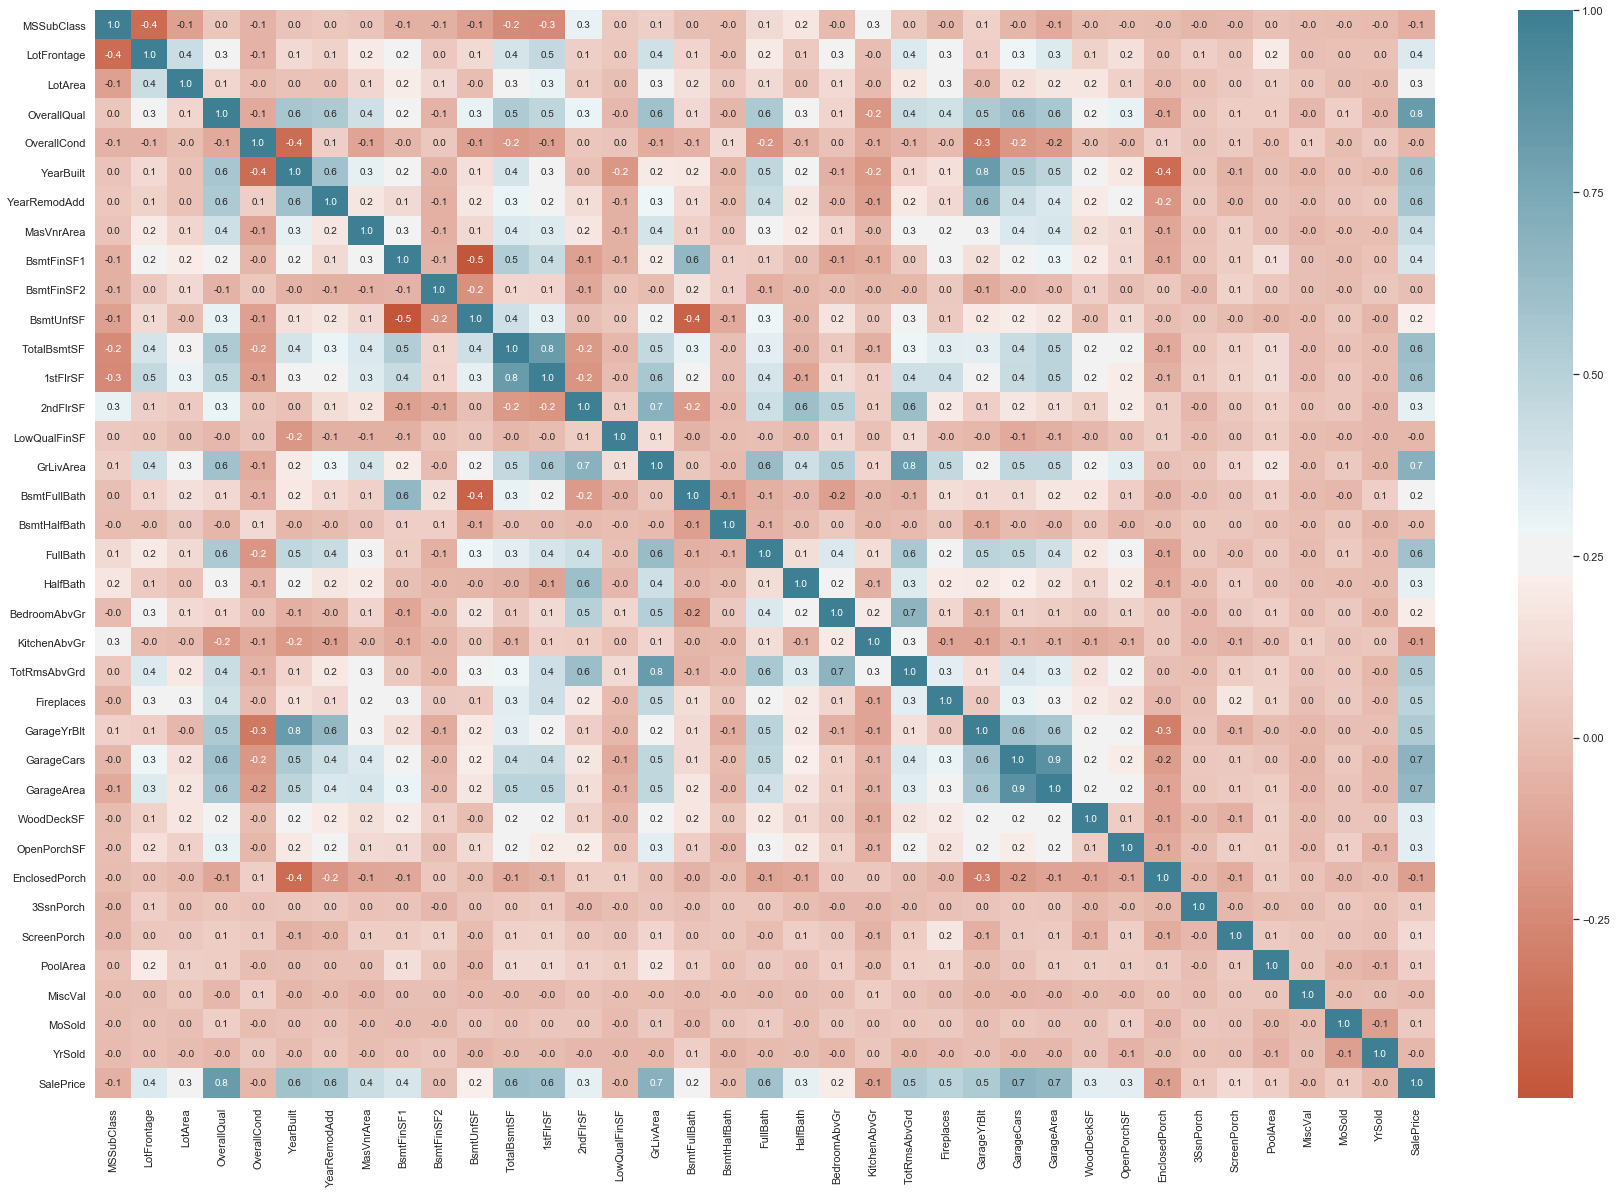

In [73]:
# 查看变量和因变量之间的相关性

plt.figure(figsize=(30,20))
correlation_train=train.corr()
sns.heatmap(correlation_train,annot=True,fmt='.1f',cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

可以看出，需要预测的`SalePrice`与`OverQual`，`GlivArea`，`GarageCars`等特征相关性较强，在0.7及以上。  
与`MasVnrArea`，`BsmtFinSF1`，`2ndFlrSF`等特征相关性较弱，小于0.5。  
与`BsmtFinSF2`，`LowQualFinSF`，`OverallCond`等特征之间的相关系数几乎为0。  
对上述几个相关性较强的特征作图展示。

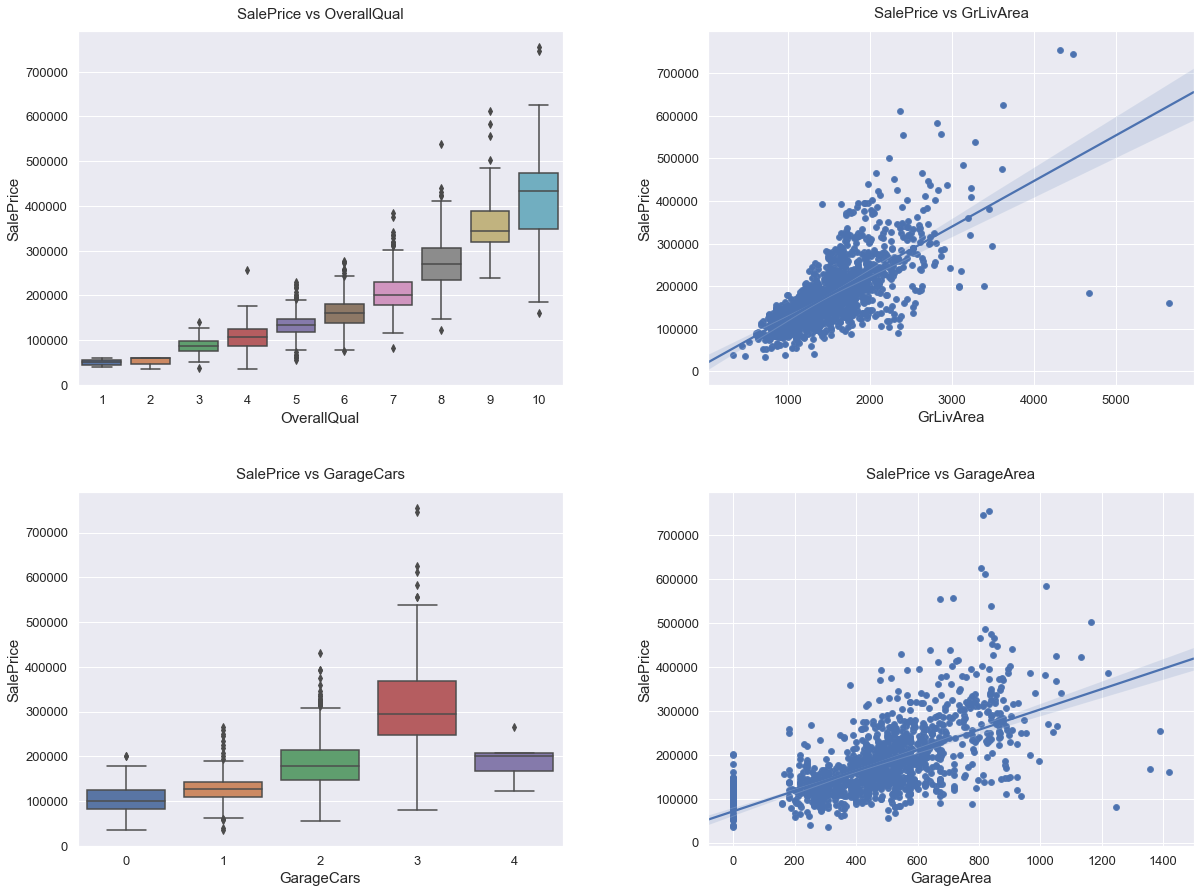

In [7]:
fig = plt.figure(figsize=(20,15))

# 调整子图间距
plt.subplots_adjust(hspace=0.3,wspace=0.3)

ax1 = fig.add_subplot(221)
sns.boxplot(x=train['OverallQual'],y=train['SalePrice'],ax=ax1)
ax1.set_title('SalePrice vs OverallQual',size=15,y=1.02)
ax1.set_xlabel('OverallQual',size=15)
ax1.set_ylabel('SalePrice',size=15)
ax1.tick_params(axis='both',labelsize=13)

ax2 = fig.add_subplot(222)
sns.scatterplot(x=train['GrLivArea'],y=train['SalePrice'],ax=ax2)
sns.regplot(x=train['GrLivArea'],y=train['SalePrice'],ax=ax2)
ax2.set_title('SalePrice vs GrLivArea',size=15,y=1.02)
ax2.set_xlabel('GrLivArea',size=15)
ax2.set_ylabel('SalePrice',size=15)
ax2.tick_params(axis='both',labelsize=13)

ax3 = fig.add_subplot(223)
sns.boxplot(x=train['GarageCars'],y=train['SalePrice'],ax=ax3)
ax3.set_title('SalePrice vs GarageCars',size=15,y=1.02)
ax3.set_xlabel('GarageCars',size=15)
ax3.set_ylabel('SalePrice',size=15)
ax3.tick_params(axis='both',labelsize=13)

ax4 = fig.add_subplot(224)
sns.scatterplot(x=train['GarageArea'],y=train['SalePrice'],ax=ax4)
sns.regplot(x=train['GarageArea'],y=train['SalePrice'],ax=ax4)
ax4.set_title('SalePrice vs GarageArea',size=15,y=1.02)
ax4.set_xlabel('GarageArea',size=15)
ax4.set_ylabel('SalePrice',size=15)
ax4.tick_params(axis='both',labelsize=13)

如图所示，随着特征值的增加，`SalePrice`大致呈现出上升的趋势，基本符合线性相关的情况。  
从散点图中可以发现存在一些异常点，比如在`SalePrice vs GrLivArea`图中，靠近右下角的2个点不太符合线性增加的情况，可以考虑剔除。

### 3.2 因变量分布情况

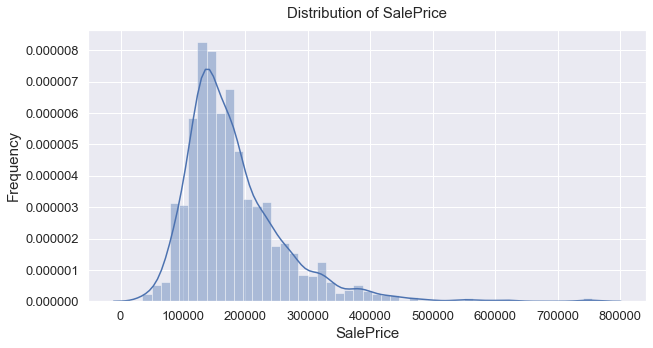

In [8]:
# 查看SalePrice的分布情况

fig = plt.figure(figsize=(10,5))

sns.distplot(train['SalePrice'],hist=True)
plt.title('Distribution of SalePrice',size=15,y=1.02)
plt.xlabel('SalePrice',size=15)
plt.ylabel('Frequency',size=15)
plt.tick_params(axis='both',labelsize=13)

plt.show()

In [9]:
print('偏度:' + str(train['SalePrice'].skew()))

偏度:1.8828757597682129


可以看出，大部分房价集中在1万-3万，少部分房价可高达7,8万，并存在右偏情况，偏度为1.88。

In [5]:
# log变换
train['SalePrice'] = np.log1p(train['SalePrice'])

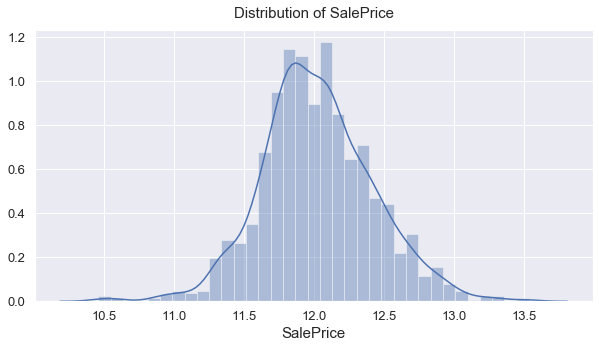

In [7]:
fig = plt.figure(figsize=(10,5))

sns.distplot(train['SalePrice'],hist=True)
plt.title('Distribution of SalePrice',size=15,y=1.02)
plt.xlabel('SalePrice',size=15)
plt.tick_params(axis='both',labelsize=13)

plt.show()

In [12]:
print('log变换后偏度:' + str(train['SalePrice'].skew()))

log变换后偏度:0.12134661989685333


通过上述简单的分析，可知：

1. 原始目标变量带有一定程度的右偏，并不完全符合正态分布，经过log变化后，大致上近似正态分布，更加符合线性回归假设。
2. 一些特征变量之间存在相关性，较强的相关性会影响线性回归模型的表现，可以考虑手动剔除，也可以交由模型处理。

In [6]:
y = train['SalePrice'].reset_index(drop=True)

In [7]:
# 将两表连接共同处理，以免存在不匹配的地方

data = pd.concat([train,test]).reset_index(drop=True)
data.drop(['SalePrice'], axis = 1, inplace = True)

In [8]:
data.shape

(2919, 79)

## 4. 特征处理

### 4.1 缺失值填补

In [9]:
def miss(df):
    '''
    返回特征变量的缺失值个数，占比，数据类型
    '''
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(ascending = False,inplace=True)
    
    per_miss = round(missing/len(df)*100,2)
    
    missing_data = pd.DataFrame({'个数':missing.values,'占比':per_miss,'数据类型':df[missing.index].dtypes})
    print('有%d个特征变量存在缺失数据' % len(missing_data))
    return missing_data

In [12]:
miss(data)

有34个特征变量存在缺失数据


,个数,占比,数据类型
PoolQC,2909,99.66,object
MiscFeature,2814,96.40,object
Alley,2721,93.22,object
Fence,2348,80.44,object
FireplaceQu,1420,48.65,object
LotFrontage,486,16.65,float64
GarageQual,159,5.45,object
GarageCond,159,5.45,object
GarageFinish,159,5.45,object
GarageYrBlt,159,5.45,float64


部分特征的`NA`表示在该房屋中不存在，因此离散型变量可用None填充，数值变量用0填充

In [10]:
missing_cat_col = ['Alley','PoolQC','MiscFeature','Fence','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
                   'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType']

for i in missing_cat_col:
    data[i] = data[i].fillna('None')

In [11]:
missing_num_col = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath', 
                    'GarageYrBlt','GarageArea','GarageCars','MasVnrArea']

for i in missing_num_col:
    data[i] = data[i].fillna(0)

In [12]:
miss(data)

有9个特征变量存在缺失数据


,个数,占比,数据类型
LotFrontage,486,16.65,float64
MSZoning,4,0.14,object
Utilities,2,0.07,object
Functional,2,0.07,object
SaleType,1,0.03,object
KitchenQual,1,0.03,object
Exterior2nd,1,0.03,object
Exterior1st,1,0.03,object
Electrical,1,0.03,object


可以看到还有9个变量存在缺失数据，其中，LotFrontage表示房屋与所处街道的距离，Neighborhood表示房屋所在街道，故在此按照Neighborhood分组再填充。

In [13]:
# 对LotFrontage用中位数填充

data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

In [14]:
# 离散型变量用众数填充

col = ['MSZoning','Utilities','Functional','SaleType','KitchenQual','Exterior2nd','Exterior1st','Electrical']

for i in col:
    data[i] = data[i].fillna(data[i].mode()[0])

In [15]:
miss(data)

有0个特征变量存在缺失数据


,个数,占比,数据类型


### 4.2 数据类型转换

部分变量为类别变量，不过用数值表示，可将其进行转换。

In [16]:
str_cols = ['MSSubClass','YrSold','MoSold','GarageYrBlt','YearRemodAdd','YearBuilt']

for i in str_cols:
    data[i] = data[i].astype(str)

### 4.3 创建新特征变量

一些变量表示着相似的意义，可以考虑合并为新特征，减少特征维度。

In [17]:
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

data['Total_Bathrooms'] = (data['FullBath']+(0.5*data['HalfBath'])+
                          data['BsmtFullBath']+(0.5*data['BsmtHalfBath']))

data['Total_porchSF'] = (data['OpenPorchSF']+data['3SsnPorch']+data['EnclosedPorch']+
                         data['ScreenPorch']+data['WoodDeckSF'])

data['BsmtfinSF'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'])

In [18]:
data.shape

(2919, 83)

### 4.4 偏度纠正

In [19]:
def fix_skew(df):
    '''
    返回特征变量修正前和修正后的偏度
    '''
    num_feature = df.dtypes[df.dtypes != 'object'].index
    
    # 计算修正前的偏度
    before_fix = df[num_feature].apply(lambda x:skew(x))
    
    # boxcox变换修正偏度
    for i in before_fix.index:
        df[i] = boxcox1p(df[i],boxcox_normmax(df[i]+1))
    
    # 计算修正后的偏度
    after_fix = df[num_feature].apply(lambda x:skew(x))
    
    dataframe = pd.DataFrame({'修正前':before_fix,'修正后':after_fix})   
    return dataframe.sort_values('修正后',ascending=False)

In [20]:
fix_skew(data)

,修正前,修正后
PoolArea,16.898328,14.985994
3SsnPorch,11.376065,8.865144
LowQualFinSF,12.088761,8.495602
MiscVal,21.947195,5.239894
BsmtHalfBath,3.931594,3.780960
KitchenAbvGr,4.302254,3.779896
ScreenPorch,3.946694,3.153911
BsmtFinSF2,4.146143,2.579467
EnclosedPorch,4.003891,2.150157
MasVnrArea,2.613592,0.976354


In [21]:
# 去除冗余特征

newdata = data.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath',
                 'OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF','BsmtFinSF2',
                 'BsmtFinSF1','PoolArea'],axis=1)

In [22]:
newdata.shape

(2919, 68)

### 4.5 类别型变量的处理

In [23]:
# 查看类别变量的分布情况

cat_feature = newdata.dtypes[newdata.dtypes == 'object'].index
counts = []
percentage = []

for i in cat_feature:
    count = newdata[i].value_counts()[0]          # 取众数出现的次数
    percen = round(count/len(newdata)*100,2)      # 计算众数所占比重
    counts.append(count)
    percentage.append(percen)
    
df = pd.DataFrame({'变量':cat_feature,'个数':counts,'占比':percentage})
df.sort_values('个数',ascending=False).head(10)

,变量,个数,占比
45,Utilities,2918,99.97
39,PoolQC,2909,99.66
44,Street,2907,99.59
9,Condition2,2889,98.97
40,RoofMatl,2876,98.53
24,Heating,2874,98.46
35,MiscFeature,2814,96.40
29,LandSlope,2778,95.17
7,CentralAir,2723,93.29
0,Alley,2721,93.22


`Utilities`，`PoolQC`，`Street`三个特征值的取值过于单一，占比高于99%，预计对后续预测任务作用不大，在此将其剔除。

In [24]:
newdata_1 = newdata.drop(['Utilities', 'Street', 'PoolQC'],axis=1)
newdata_1.shape

(2919, 65)

In [25]:
# labelencoder编码

label_features = ['YearRemodAdd','GarageYrBlt','YearBuilt']

for i in label_features:
    newdata_1[i] = LabelEncoder().fit_transform(newdata_1[i])

In [26]:
# 哑变量编码

final_data = pd.get_dummies(newdata_1).reset_index(drop=True)
print(final_data.shape)

(2919, 313)


In [27]:
# 重新拆分训练集和测试集

x = final_data.iloc[:1460,:]
x_test = final_data.iloc[1460:,:]
print('x', x.shape,'x_test', x_test.shape)

x (1460, 313) x_test (1459, 313)


### 4.6 异常值检测

In [28]:
# 3sigma异常值检测

def three_sigma(x,y,c='red',plot=True):
    '''
    返回异常值索引
    '''
    high = x.mean() + 3*x.std()
    low = x.mean() - 3*x.std()
    out_ind = x[(x>high)|(x<low)].index
    
    if plot:
        plt.figure(figsize=(10, 8))
        plt.scatter(x=x, y=y)
    
        # 在图中标注出异常点
        for i in range(len(out_ind)):
            plt.plot(x[out_ind[i]],y[out_ind[i]],'*',color=c,markersize=15)
    
    return out_ind

Int64Index([29, 523, 533, 691, 916, 1100, 1182, 1298], dtype='int64')

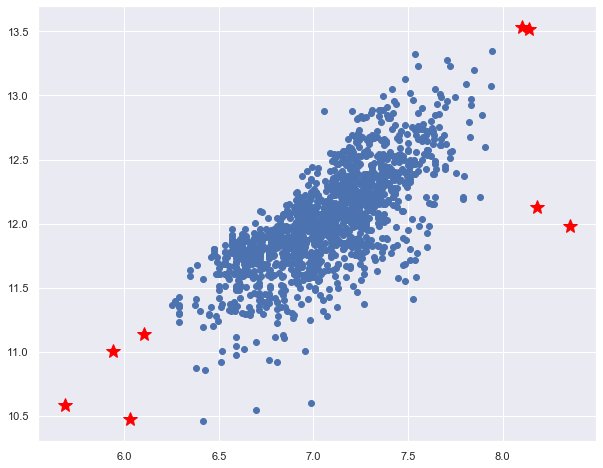

In [39]:
three_sigma(x['GrLivArea'],y)

In [29]:
out_cols = newdata_1.dtypes[newdata_1.dtypes != 'object'].index
outliers = []

for i in out_cols:
    outlier = three_sigma(x[i],y,plot=False) 
    outliers.extend(outlier)

# 用Counter进行频数统计，返回一个dict
out_dict = Counter(outliers)
print(out_dict)

Counter({1298: 7, 635: 4, 533: 4, 53: 3, 634: 3, 1350: 3, 523: 3, 691: 3, 1100: 3, 1182: 3, 144: 2, 330: 2, 570: 2, 843: 2, 897: 2, 1163: 2, 1061: 2, 1190: 2, 420: 2, 916: 2, 17: 2, 676: 2, 705: 2, 921: 2, 1230: 2, 249: 2, 313: 2, 335: 2, 197: 2, 51: 2, 88: 2, 589: 2, 250: 2, 1328: 2, 375: 2, 189: 1, 291: 1, 1213: 1, 1270: 1, 166: 1, 309: 1, 605: 1, 642: 1, 178: 1, 581: 1, 664: 1, 825: 1, 747: 1, 1340: 1, 29: 1, 8: 1, 9: 1, 39: 1, 48: 1, 74: 1, 78: 1, 93: 1, 102: 1, 137: 1, 165: 1, 188: 1, 246: 1, 342: 1, 441: 1, 454: 1, 488: 1, 505: 1, 520: 1, 529: 1, 637: 1, 703: 1, 728: 1, 736: 1, 778: 1, 809: 1, 886: 1, 894: 1, 910: 1, 913: 1, 940: 1, 942: 1, 943: 1, 954: 1, 955: 1, 984: 1, 1003: 1, 1011: 1, 1030: 1, 1062: 1, 1090: 1, 1186: 1, 1216: 1, 1232: 1, 1266: 1, 1275: 1, 1283: 1, 1292: 1, 1336: 1, 1391: 1, 1393: 1, 1412: 1, 1416: 1, 1450: 1, 75: 1, 225: 1, 232: 1, 235: 1, 363: 1, 384: 1, 430: 1, 451: 1, 457: 1, 489: 1, 614: 1, 655: 1, 661: 1, 706: 1, 769: 1, 837: 1, 848: 1, 956: 1, 1029: 1,

In [30]:
out_list = []

for key,value in out_dict.items():
    if value>=3:
        out_list.append(key)
        
print(out_list)
print(len(out_list))

[53, 634, 635, 1350, 1298, 523, 533, 691, 1100, 1182]
10


In [31]:
# 去掉异常值

x_ = x.drop(x.index[out_list])
x_.reset_index(drop=True,inplace=True)
y_ = y.drop(y.index[out_list]).reset_index(drop=True)
print(x_.shape,y_.shape)

(1450, 313) (1450,)


In [32]:
# 检查是否存在重复值
x_.duplicated().sum()

0

线性回归需要对特征变量做归一化，常用的有`MaxMinScaler`，`StandardScaler`，不过这二者容易受异常值影响，而`RobustScaler`的鲁棒性会稍好一些。

In [33]:
scaler = RobustScaler()

x_scaler = scaler.fit_transform(x_)
x_test_scaler = scaler.transform(x_test)

## 5. 建模预测

先定义2个函数，`rmse_cv`用于输出交叉验证评分，`params_score`用来输出后续网格搜索过程中不同参数组合的对应评分

In [34]:
kfolds = KFold(n_splits=10,shuffle=True,random_state=42)

def rmse_cv(model,x,y=y_):
    '''
    返回交叉验证评分
    '''
    score = np.sqrt(-cross_val_score(model,x,y=y_,scoring='neg_mean_squared_error',cv=kfolds))
    return print('交叉验证分数:' + str(score.mean()))

In [35]:
def params_score(gs_CV):
    '''
    返回最佳参数组合及对应的评分
    '''
    print("当前最佳参数及得分：\n{} {}".format(gs_CV.best_params_,np.sqrt(-gs_CV.best_score_)))
    print('各参数对应得分：')
    for p,s in zip(gs_CV.cv_results_['params'],gs_CV.cv_results_['mean_test_score']):
        print(p,np.sqrt(-s))

### 5.1 Lasso

In [55]:
# Lasso回归

# param_grid = {'alpha':[0.00038,0.0004,0.00042,0.00045,0.0005]}

# lasso = Lasso(random_state=42)

# gs = GridSearchCV(lasso,param_grid=param_grid,scoring='neg_mean_squared_error',cv=kfolds)
# gs = gs.fit(x_scaler,y_)

# params_score(gs)

当前最佳参数及得分：
{'alpha': 0.0004} 0.10836168554008571
各参数对应得分：
{'alpha': 0.00038} 0.10836347300888452
{'alpha': 0.0004} 0.10836168554008571
{'alpha': 0.00042} 0.10837552176808345
{'alpha': 0.00045} 0.1084117772243848
{'alpha': 0.0005} 0.108490125933


In [36]:
# Lasso回归
lasso = Lasso(alpha=0.0004,random_state=42)
rmse_cv(lasso,x_scaler)

交叉验证分数:0.10739795817533579


### 5.2 Ridge

In [37]:
# 岭回归
ridge = Ridge(alpha=12.5,random_state=42)
rmse_cv(ridge,x_scaler)

交叉验证分数:0.10939620519881763


### 5.3 弹性网

In [38]:
# 弹性网
EN = ElasticNet(alpha=0.00045,l1_ratio=0.85,random_state=42)
rmse_cv(EN,x_scaler)

交叉验证分数:0.10740564734189786


### 5.4 SVM

In [39]:
svr = SVR(C=2,epsilon=0.05,gamma=0.0042)
rmse_cv(svr,x_scaler)

交叉验证分数:0.1071186191231552


### 5.5 GBDT

In [40]:
gbr = GradientBoostingRegressor(n_estimators=1500,
                                learning_rate=0.05,
                                min_samples_split=5,
                                min_samples_leaf=2,
                                max_depth=3,
                                loss='huber',
                                max_features='sqrt',
                                random_state=42)

rmse_cv(gbr,x_scaler)

交叉验证分数:0.11271234103073377


### 5.6 XGB

In [41]:
xgb = XGBRegressor(booster='gbtree',
                   n_estimators=1200,
                   max_depth=3,
                   learning_rate=0.03,
                   reg_lambda=0.4,
                   gamma=0,
                   subsample=0.9,
                   colsample_bytree=0.5,
                   min_child_weight=6
                  )

rmse_cv(xgb,x_scaler)

交叉验证分数:0.11013650109666258


通过交叉验证，发现SVM的表现最好，提交后在测试集上得分为`0.11761`，后续通过模型融合来进一步提升模型表现。

In [42]:
# stacking

stack = StackingCVRegressor(regressors=(lasso,ridge,EN,svr,gbr,xgb),random_state=42,
                           meta_regressor=lasso)
rmse_cv(stack,x_scaler)

交叉验证分数:0.10504431208185602


In [43]:
# 模型拟合

final_lasso = lasso.fit(x_scaler,y_) # 0.107397
final_ridge = ridge.fit(x_scaler,y_) # 0.109396
final_EN = EN.fit(x_scaler,y_) # 0.107405
final_svr = svr.fit(x_scaler,y_) # 0.107112
final_gbr = gbr.fit(x_scaler,y_) # 0.112712
final_xgb = xgb.fit(x_scaler,y_) # 0.110136
final_stack = stack.fit(x_scaler,y_) # 0.1050443

In [44]:
# 线性融合,自定义权重系数

def blend_model_predict(dataset):
    return (
            (0.1 * final_lasso.predict(dataset))+
            (0.05 * final_ridge.predict(dataset))+
            (0.1 * final_EN.predict(dataset))+
            (0.2 * final_svr.predict(dataset))+
            (0.05 * final_gbr.predict(dataset))+
            (0.05 * final_xgb.predict(dataset))+
            (0.45 * final_stack.predict(dataset))
           )

### 5.7  最后预测

In [45]:
# 模型预测

sub_pred_l = np.expm1(blend_model_predict(x_test_scaler))
sub = pd.DataFrame({'Id':test_id,'SalePrice':sub_pred_l})
sub.to_csv('price.csv',index=False)

最终模型得分为0.11641，虽然整个模型相比起SVM只提升了0.001左右，不过在排名上倒是前进了100来位。